# What is EDA (Exploratory Data Analysis)?

EDA is the first step in any data science or machine learning workflow.

**Purpose:**
- Understand the data before modeling.
- Detect patterns, trends, anomalies, and relationships.
- Check distributions, scales, and potential outliers.

**Common EDA tools:**
- Scatter plots (relationships).
- Histograms (distribution).
- Summary statistics (`pandas.DataFrame.describe()`).
- Correlation matrices.

**Best practice:** Perform EDA on the **training set only** to avoid leaking information from the test set.


# Exercise: EDA → Heteroscedastic Linear Data (600 pts) → Train/Test → OP vs PO + Residual fits + Metrics

This notebook walks through: (1) split-first EDA, (2) linear model fitting with scikit-learn, (3) proper evaluation on the test set with OP vs PO plots, (4) metrics (MAE/MSE/R²), and (5) residual diagnostics with fitted trend lines.

In [11]:
# Requirements: numpy, pandas, matplotlib, scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = False
print('Imports OK')


Imports OK
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 1) Create the data (heteroscedastic, N=600)
Noise standard deviation increases linearly from 5 to 50 as x grows.

In [12]:
N = 600
rng = np.random.default_rng(seed=42)
X = np.arange(1, N + 1, dtype=float).reshape(-1, 1)
w = (X.ravel() - X.min()) / (X.max() - X.min())
sigma_min, sigma_max = 5.0, 50.0
sigma = sigma_min + (sigma_max - sigma_min) * w
eps = rng.normal(loc=0.0, scale=sigma, size=N)
Y = X.ravel() + eps
X[:5].ravel(), Y[:5], sigma[:5]  # peek

(array([1., 2., 3., 4., 5.]),
 array([ 2.5235854 , -3.27804955,  6.86501158,  8.91480394, -5.34146365]),
 array([5.        , 5.07512521, 5.15025042, 5.22537563, 5.30050083]))

## 2) Train/Test Split
Fit on **train**, evaluate on **test**. EDA below uses **train only**.

In [13]:
X_train, X_test, y_train, y_test, sigma_train, sigma_test = train_test_split(
    X, Y, sigma, test_size=0.30, random_state=123, shuffle=True
)
len(X_train), len(X_test)

(420, 180)

## 3) EDA (train only): scatter, histogram, and `pandas.DataFrame.describe()`
Keep it simple and fast; the goal is to understand scale, distribution, and relationship before fitting.

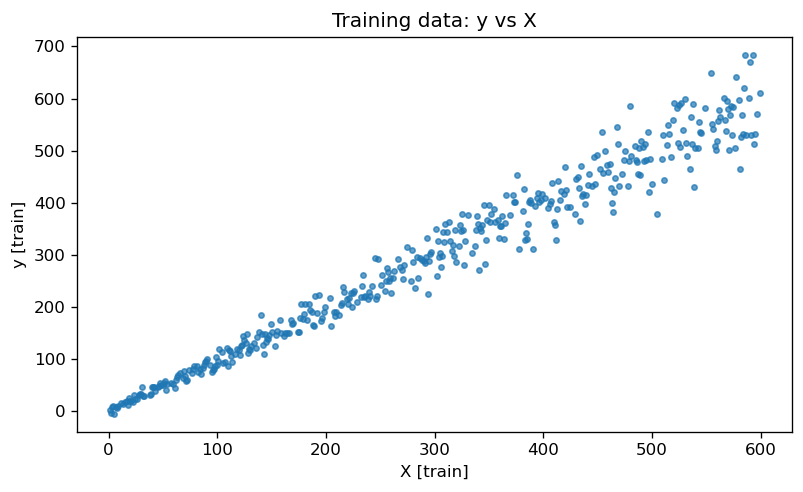

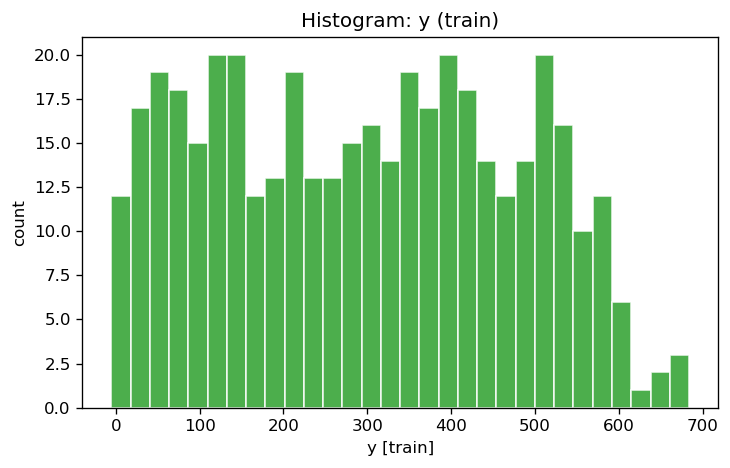

,X,y
count,420.000000,420.000000
mean,297.766667,295.875515
std,174.889622,176.581619
min,1.000000,-5.341464
25%,142.750000,142.959219
50%,301.500000,296.015662
75%,448.250000,435.527808
max,599.000000,683.764164


TRAIN correlation corr(X,y) = 0.984


In [14]:
# Build a small DataFrame for TRAIN
df_train = pd.DataFrame({'X': X_train.ravel(), 'y': y_train})

# 3A) Scatter: X vs y (train)
plt.figure(figsize=(6.8, 4.2))
plt.scatter(df_train['X'], df_train['y'], s=10, alpha=0.7, color='tab:blue')
plt.xlabel('X [train]')
plt.ylabel('y [train]')
plt.title('Training data: y vs X')
plt.tight_layout(); plt.show()

# 3B) Histogram of y (train)
plt.figure(figsize=(6.2, 4.0))
df_train['y'].plot(kind='hist', bins=30, color='tab:green', alpha=0.85, edgecolor='white')
plt.xlabel('y [train]')
plt.ylabel('count')
plt.title('Histogram: y (train)')
plt.tight_layout(); plt.show()

# 3C) Simple statistical description with pandas
display(df_train.describe())

# 3D) Quick correlation (train)
corr = df_train[['X','y']].corr().loc['X','y']
print(f'TRAIN correlation corr(X,y) = {corr:.3f}')


> **Callout: What does `pandas.DataFrame.describe()` show?**
>> - **count**: number of non-null observations.
>> - **mean / std**: central tendency and spread.
>> - **min, 25%, 50%, 75%, max**: five-number summary.
>> - Use it to quickly check scale, spread, and outliers/skew before modeling.
>> 👉 *Best practice:* perform EDA on the **training set only** to avoid test leakage.


### About scikit-learn and LinearRegression
`scikit-learn` is a widely used Python library for machine learning.
- Provides tools for regression, classification, clustering, preprocessing, and model evaluation.
- `LinearRegression` implements Ordinary Least Squares (OLS) for fitting a linear model: 
  $$ \hat{y} = aX + b $$
- Assumes a linear relationship between predictors and response.
- In this exercise, we use it to fit a simple 1D linear model on the training data.


## 4) Fit a linear model on TRAIN only
We fit $\hat Y = aX + b$ using ordinary least squares.

In [15]:
lin = LinearRegression().fit(X_train, y_train)
a, b = lin.coef_[0], lin.intercept_
print(f'Fit on TRAIN: Y_hat = {a:.3f} * X + {b:.3f}')


Fit on TRAIN: Y_hat = 0.994 * X + -0.065


## 5) Predict on TEST


In [16]:
yhat_test = lin.predict(X_test)
yhat_test[:5]  # peek

array([365.67810211,  54.59775495, 544.57414841, 346.79463056,
       398.4757106 ])

### Plot Interpretation
- **OP plot (Observed vs Predicted):**
  - Observed values on y-axis, predicted on x-axis.
  - Overlay 1:1 line: ideal predictions fall on this line.
  - OP regression line close to 1:1 indicates unbiased predictions.
- **PO plot (Predicted vs Observed):**
  - Swapping axes distorts slope/intercept; misleading for bias checks.
- **Residual plots:**
  - Residuals vs predicted (correct): should center around 0; spread pattern reveals heteroscedasticity.
  - Residuals vs true (pitfall): can show spurious trends because y contains noise.


## 6) OP plot (Observed vs Predicted) — **correct** evaluation on TEST
Scatter **y** (y-axis) vs **\^y** (x-axis); overlay the 1:1 line and the OP regression line.

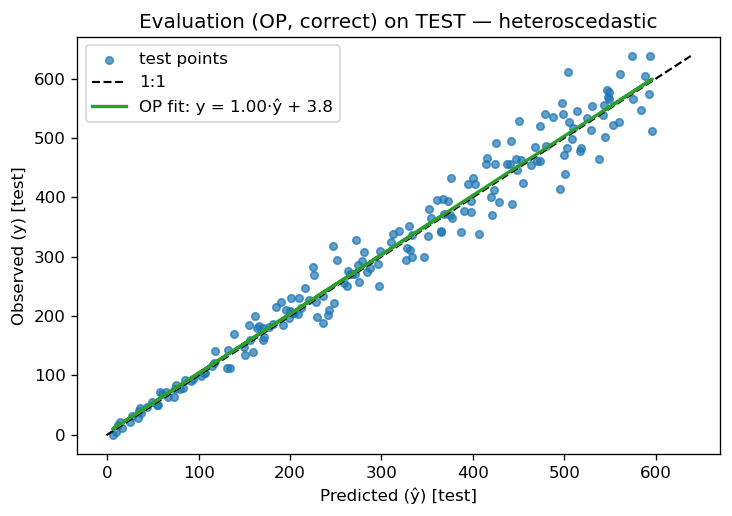

In [17]:
def fit_line(x, y):
    lr = LinearRegression().fit(x.reshape(-1,1), y)
    return lr.coef_[0], lr.intercept_, lr.predict(x.reshape(-1,1))

slope_op, intercept_op, y_op_line = fit_line(yhat_test, y_test)
xy_min = min(y_test.min(), yhat_test.min())
xy_max = max(y_test.max(), yhat_test.max())
grid = np.linspace(xy_min, xy_max, 100)

plt.figure(figsize=(6.2, 4.4))
plt.scatter(yhat_test, y_test, s=20, alpha=0.7, label='test points')
plt.plot(grid, grid, 'k--', lw=1.3, label='1:1')
plt.plot(yhat_test, y_op_line, color='tab:green', lw=2, label=f'OP fit: y = {slope_op:.2f}·ŷ + {intercept_op:.1f}')
plt.xlabel('Predicted (ŷ) [test]')
plt.ylabel('Observed (y) [test]')
plt.title('Evaluation (OP, correct) on TEST — heteroscedastic')
plt.legend(); plt.tight_layout(); plt.show()


### Performance Indicators Explained
- **MAE (Mean Absolute Error):** Average absolute difference between predictions and true values.
  - Easy to interpret; less sensitive to outliers than MSE.
- **MSE (Mean Squared Error):** Average squared difference between predictions and true values.
  - Penalizes large errors more heavily.
- **R² (Coefficient of Determination):** Proportion of variance in observed values explained by predictions.
  - Ranges from 0 to 1 (higher is better).
  - Can be negative if the model performs worse than predicting the mean.


## 6b) Performance metrics on TEST (scikit-learn)
Compute **MAE**, **MSE**, and **R²** on the **test set**.

In [18]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2  = r2_score(y_test, yhat_test)
print(f'MAE (test): {mae:.3f}')
print(f'MSE (test): {mse:.3f}')
print(f'R^2 (test): {r2:.3f}')


MAE (test): 22.322
MSE (test): 906.279
R^2 (test): 0.969


## 7) PO plot (Predicted vs Observed) — **pitfall** on TEST
Swapping axes changes slope/intercept even if $R^2$ stays the same; evaluating with PO can lead to biased conclusions.

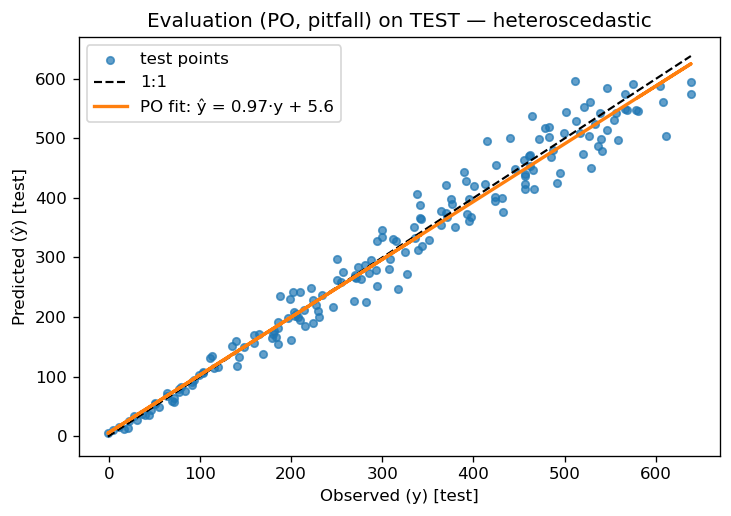

In [19]:
slope_po, intercept_po, y_po_line = fit_line(y_test, yhat_test)

plt.figure(figsize=(6.2, 4.4))
plt.scatter(y_test, yhat_test, s=20, alpha=0.7, label='test points')
plt.plot(grid, grid, 'k--', lw=1.3, label='1:1')
plt.plot(y_test, y_po_line, color='tab:orange', lw=2, label=f'PO fit: ŷ = {slope_po:.2f}·y + {intercept_po:.1f}')
plt.xlabel('Observed (y) [test]')
plt.ylabel('Predicted (ŷ) [test]')
plt.title('Evaluation (PO, pitfall) on TEST — heteroscedastic')
plt.legend(); plt.tight_layout(); plt.show()


## 8) Residual plots on TEST **with fitted trend lines**
- **Correct**: residuals vs predicted (ŷ) — center should be ~0; spread increases.
- **Pitfall**: residuals vs true (y) — misleading structure may appear since y contains noise.

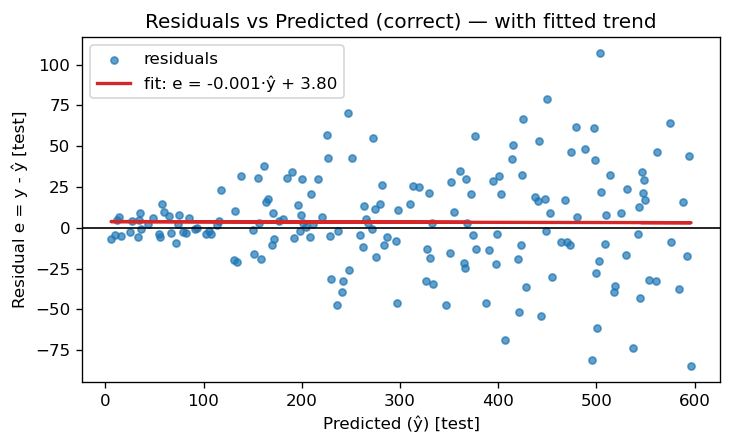

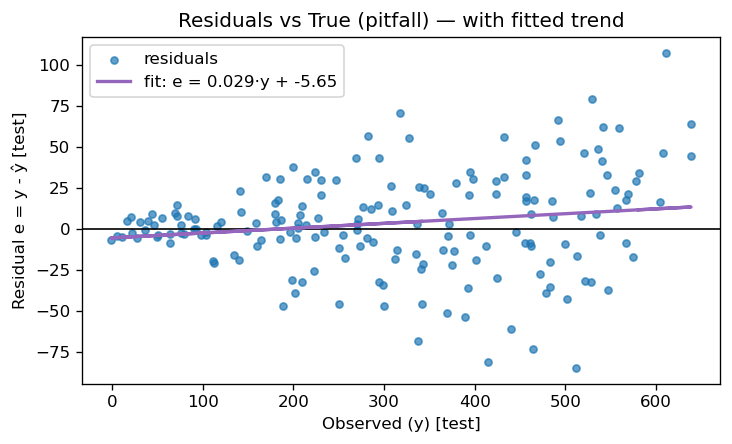

In [20]:
res_test = y_test - yhat_test

# Residuals vs Predicted (correct) + fitted trend line
slope_rp, intercept_rp, res_fit_pred = fit_line(yhat_test, res_test)
plt.figure(figsize=(6.2, 3.8))
plt.scatter(yhat_test, res_test, s=18, alpha=0.7, label='residuals')
plt.axhline(0, color='k', lw=1)
plt.plot(yhat_test, res_fit_pred, color='tab:red', lw=2, label=f'fit: e = {slope_rp:.3f}·ŷ + {intercept_rp:.2f}')
plt.xlabel('Predicted (ŷ) [test]')
plt.ylabel('Residual e = y - ŷ [test]')
plt.title('Residuals vs Predicted (correct) — with fitted trend')
plt.legend(); plt.tight_layout(); plt.show()

# Residuals vs True (pitfall) + fitted trend line
slope_rt, intercept_rt, res_fit_true = fit_line(y_test, res_test)
plt.figure(figsize=(6.2, 3.8))
plt.scatter(y_test, res_test, s=18, alpha=0.7, label='residuals')
plt.axhline(0, color='k', lw=1)
plt.plot(y_test, res_fit_true, color='tab:purple', lw=2, label=f'fit: e = {slope_rt:.3f}·y + {intercept_rt:.2f}')
plt.xlabel('Observed (y) [test]')
plt.ylabel('Residual e = y - ŷ [test]')
plt.title('Residuals vs True (pitfall) — with fitted trend')
plt.legend(); plt.tight_layout(); plt.show()
